```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

Run deterministic forecast for comparison with OpenDrift and NorKyst.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [2]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset

#Helpful during development
import importlib
#importlib.reload(module)

import datetime

from IPython.display import display

import matplotlib

from matplotlib import pyplot as plt
#Set large figure sizes
#plt.rcParams["animation.html"] = "jshtml" #Javascript 
plt.rcParams["animation.html"] = "html5" #mp4
plt.rcParams["figure.dpi"] = 100.0 #highres movies/plots

plt.rcParams["animation.writer"] = 'ffmpeg' 
plt.rcParams["animation.codec"] = 'h264' 

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'

In [3]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

from SWESimulators import CDKLM16, Common, IPythonMagic, NetCDFInitialization
from SWESimulators import GPUDrifterCollection, Observation
from SWESimulators import DataAssimilationUtils as dautils

from demos.realisticSimulations import norkyst_plotting

In [4]:
%cuda_context_handler gpu_ctx

# Analyse a given DA experiment

In [5]:
result_folder1, description1 = 'EPS_30821_2019_12_05-21_42_22/', '48 hours DA, resampling every 5 min (bad drifter)'

result_folder5min, description5min = 'ensemble2_48h_experiments/EPS_31153_2019_12_09-18_38_03/', '48 hours DA, resampling every 5 min'
result_folder30min, description30min = 'ensemble2_48h_experiments/EPS_31154_2019_12_09-23_19_08/', '48 hours DA, resampling every 30 min'



In [22]:
def analyse_resampling(result_folder, description):

    resampling_folder = os.path.join(result_folder, 'resampling')
    resampling_files = os.listdir(resampling_folder)

    num_resampling_steps = len(resampling_files)
    
    # Print some info about the first iteration
    print('Analysing: ' + description)
    print('------------------')
    print('num_resampling_steps: ', num_resampling_steps)

    print('Info about the first iteration:')
    weight, resample_ids = np.load(os.path.join(resampling_folder, resampling_files[0]))
    print('First resampling step')
    print('max weight', weight.max())
    print('particles with w > 1%: ', np.count_nonzero(weight > 0.001))
    print('weights > 1%: ', weight[weight > 0.01], weight[weight > 0.001].sum())
    print('num_resampled_particles: ', len(np.unique(resample_ids)))
    
    # Crunch the numbers
    num_resampled_particles = np.zeros(num_resampling_steps)
    weight_max = np.zeros(num_resampling_steps)
    particles_with_weight_more_than_one = np.zeros(num_resampling_steps)

    for i in range(num_resampling_steps):
        weight, resample_ids = np.load(os.path.join(resampling_folder, resampling_files[i]))

        num_resampled_particles[i] = len(np.unique(resample_ids))
        weight_max[i] = weight.max()
        particles_with_weight_more_than_one[i] = np.count_nonzero(weight > 0.01)

    # Print some worst case scenarios:
    print('---------------')
    print('Some worst case scenarios:')
    print('weight_max.min(), weight_max.max(), weight_max.argmax():', weight_max.min(), weight_max.max(), weight_max.argmax())
    print('Number of times the max weight is over 50%: ', np.count_nonzero(weight_max > 0.5))
    print('Iterations and max weigths when the max weight is over 50%:')
    for i in range(num_resampling_steps):
        if (weight_max[i] > 0.5):
            print(i, weight_max[i])
    
    fig = plt.figure(figsize=(15,4))
    plt.plot(num_resampled_particles)
    plt.grid()
    plt.xlabel('Resampling step')
    plt.ylabel('Num resampled particles')
    plt.title(description)
    
    fig = plt.figure(figsize=(15,4))
    plt.plot(weight_max)
    plt.grid()
    plt.xlabel('Resampling step')
    plt.ylabel('Max weight')
    plt.title(description)
    
    fig = plt.figure(figsize=(6,4))
    plt.hist(weight_max, bins=20, range=(0, 1), edgecolor='black', linewidth=0.4)
    plt.ylabel('Occurences')
    plt.xlabel('Max weight')
    plt.title(description)
    
    fig = plt.figure(figsize=(15,4))
    plt.plot(particles_with_weight_more_than_one)
    plt.grid()
    plt.xlabel('Resampling step')
    plt.ylabel('Particles with w > 1%')
    plt.title(description)

Analysing: 48 hours DA, resampling every 5 min (bad drifter)
------------------
num_resampling_steps:  576
Info about the first iteration:
First resampling step
max weight 0.22230722299593236
particles with w > 1%:  80
weights > 1%:  [0.08712753 0.0122069  0.04941752 0.06119526 0.22230722 0.12320515
 0.01049516 0.01896189 0.09939491] 0.9257617724968663
num_resampled_particles:  144
---------------
Some worst case scenarios:
weight_max.min(), weight_max.max(), weight_max.argmax(): 0.007511401572021662 0.9999293677947829 375
Number of times the max weight is over 50%:  6
Iterations and max weigths when the max weight is over 50%:
70 0.8179203766568054
78 0.8692581696099027
188 0.8563480196703869
288 0.5083947482263749
360 0.5418267482344533
375 0.9999293677947829


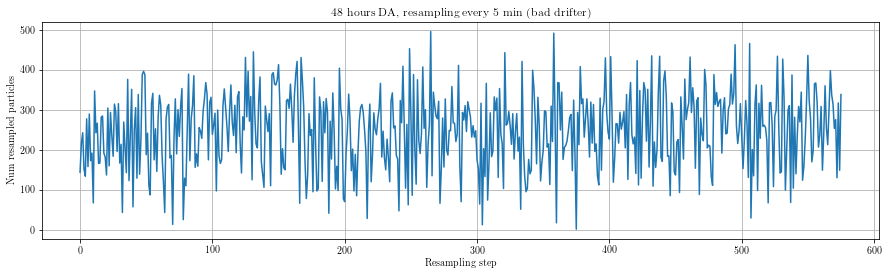

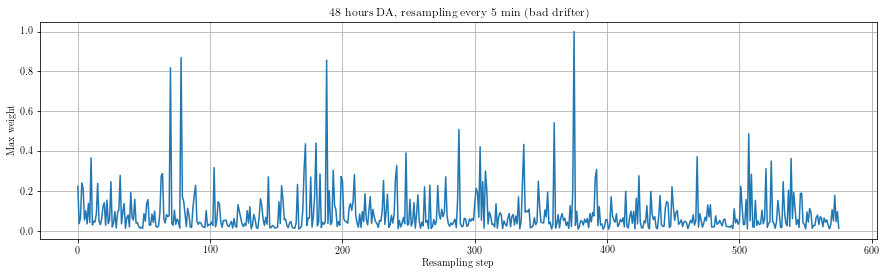

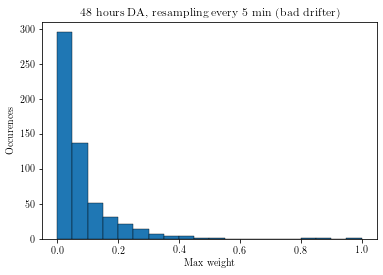

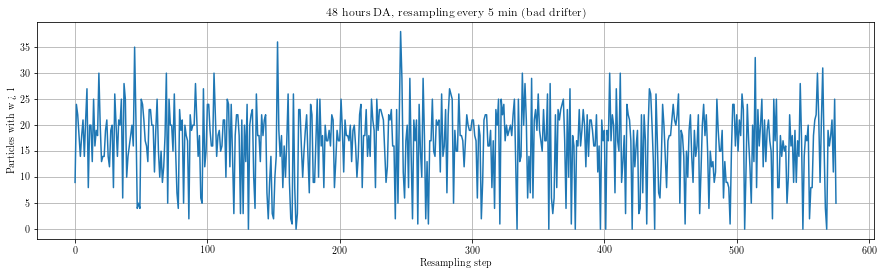

In [23]:
analyse_resampling(result_folder1, description1)

Analysing: 48 hours DA, resampling every 5 min
------------------
num_resampling_steps:  576
Info about the first iteration:
First resampling step
max weight 0.3896248589897704
particles with w > 1%:  28
weights > 1%:  [0.01932521 0.11998459 0.01707723 0.06042647 0.07605141 0.06857135
 0.12054758 0.38962486 0.01302035 0.01776374 0.02481145] 0.9871744214005627
num_resampled_particles:  36
---------------
Some worst case scenarios:
weight_max.min(), weight_max.max(), weight_max.argmax(): 0.0066743040227013216 0.9759392509025541 453
Number of times the max weight is over 50%:  25
Iterations and max weigths when the max weight is over 50%:
3 0.7057063272877827
52 0.7371898238821691
91 0.9059016901093312
179 0.5567556487946647
199 0.5605265945470507
203 0.5315770550718367
204 0.5795533584912719
210 0.5639461570366135
263 0.5889289992362774
294 0.7406319852138035
304 0.5031327605169711
306 0.6624611127455937
335 0.5617716969501859
348 0.7695884972097968
353 0.5365545403431973
412 0.618649360

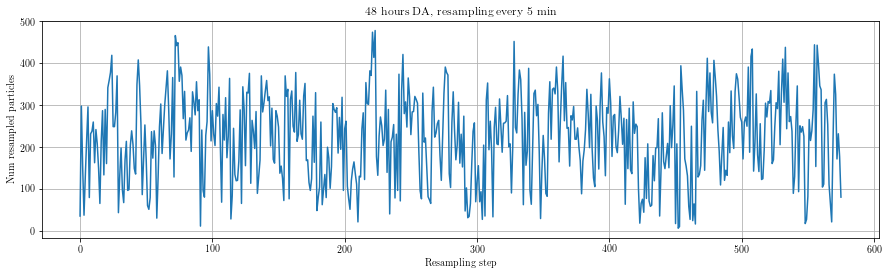

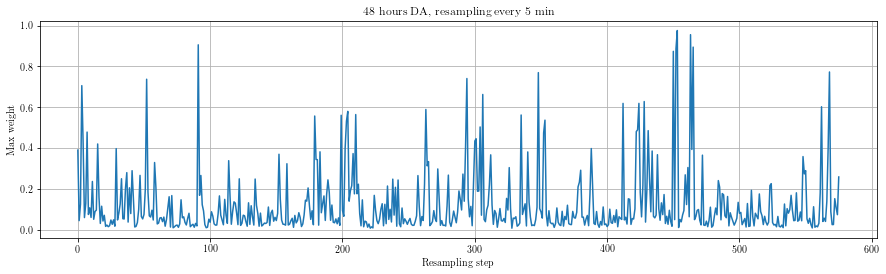

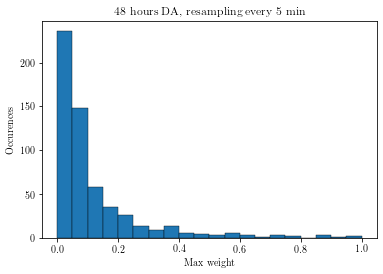

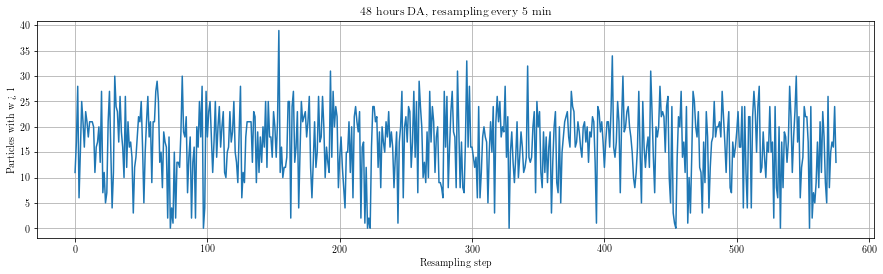

In [24]:
analyse_resampling(result_folder5min, description5min)

Analysing: 48 hours DA, resampling every 30 min
------------------
num_resampling_steps:  96
Info about the first iteration:
First resampling step
max weight 0.906500021182498
particles with w > 1%:  13
weights > 1%:  [0.02992527 0.90650002 0.02164611] 0.9883586969208603
num_resampled_particles:  23
---------------
Some worst case scenarios:
weight_max.min(), weight_max.max(), weight_max.argmax(): 0.013640730070522328 0.9991438568109281 92
Number of times the max weight is over 50%:  33
Iterations and max weigths when the max weight is over 50%:
0 0.906500021182498
1 0.7079081642718806
2 0.9544814099213319
3 0.5358877623101445
5 0.7881568502380116
7 0.9649375760561074
8 0.9362845399988985
9 0.82365573532332
12 0.7373216270386779
17 0.9550753545932544
23 0.8846533573463764
27 0.899198371905356
29 0.81508661487973
35 0.6313821794729522
42 0.97611185660198
43 0.9937409100405226
46 0.5110472668371785
47 0.9081759374254823
49 0.7769558837065541
51 0.8151468721883268
52 0.6745124120038966
55

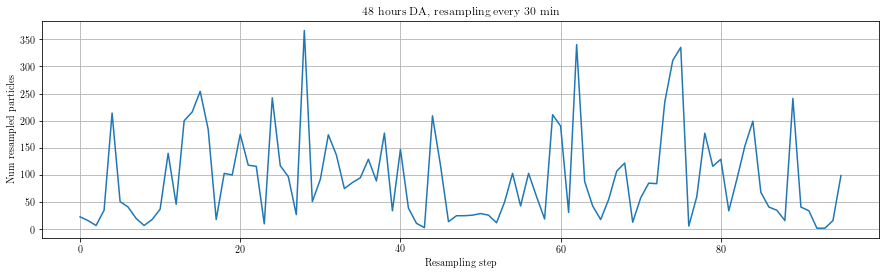

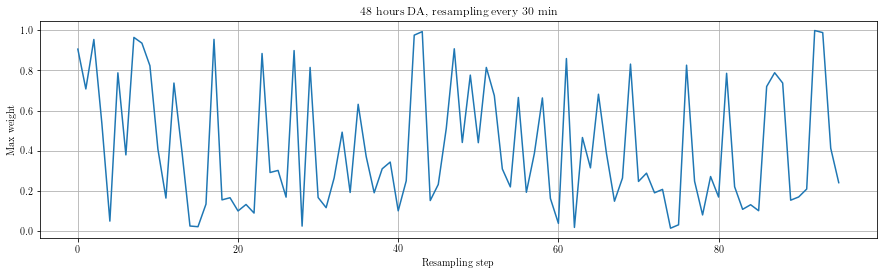

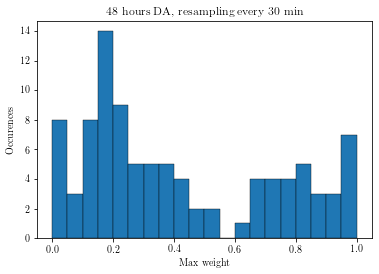

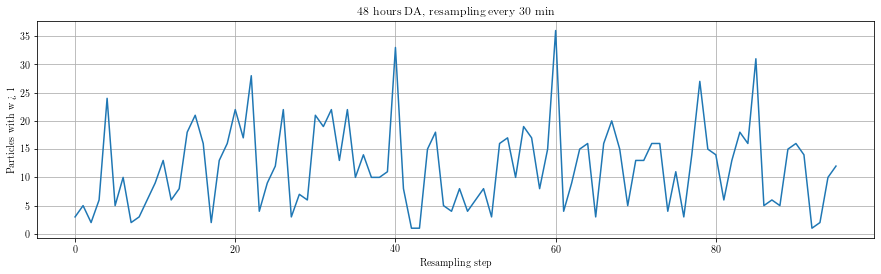

In [25]:
analyse_resampling(result_folder30min, description30min)